# Policy-based method: REINFORCE

Now that we've implemented a value-based algorithm, it's only right that we should try out a policy-based one as well, right ? So let's learn about REINFORCE !

**Key facts**:
- It was first defined in ['Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning' by Ronald J. WILLIAMS in 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf?pdf=button).
- It uses a **monte carlo** method

### Monte Carlo

As explained in the previous notebook, you can think of Monte Carlo as a method in which our agent learns after each episode instead of doing so at each time step like Temporal Difference.

This implies that there is no need to estimate the target: we can compute the episodic reward for each timestep using the memory batch:

![Monte Carlo formula](./assets/fig13.svg)

Let's begin by implementing this formula !


But before we begin, let's import some modules and define some constants...\
Notice this time we're using pytorch because it will make it easier for us to deal with optimization since pytorch has a built in 'Adam' optimizer which will improve our `REINFORCE` algorithm.

In [1]:
# Import necessary libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Set the learning rate and discount factor
lr = 1e-3
gamma = 0.995

# Set the number of episodes to run
episodes = 300

## OpenAI Gym

From now on, we will be using a popular RL framework called OpenAI Gym !

In [2]:
import gymnasium

# Set the environment to use
env_name = 'CartPole-v1'

# Create the environment
env = gymnasium.make(env_name, render_mode="rgb_array")

We will `make` our gym environment by providing an environment name. Here, we choose the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). Feel free to take some time to read its documentation.

![Cart pole](./assets/fig14.gif)
> gif representing the cartpole environment taken from the official documentation

Let's see what information we can retrieve from the `env` variable...

In [3]:
print(f'Action space: {env.action_space} ({env.action_space.n} possible actions)')

Action space: Discrete(2) (2 possible actions)


The action space is `Discrete(2)`, a discrete action space with 2 possible actions.

A discrete action space means there is a finite set of actions that the agent can take, for example going left or right. On the contrary, a continuous action space means the actions can depend on various variables, like for example all the different ways you can move a pawn, as well as all the different ways you can move a knight and so on in a chess game.

In [4]:
print(f'Observation space: {env.observation_space}')
print()
print(f'State shape: {env.observation_space.shape}')

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

State shape: (4,)


The Observation space is of shape (4,) meaning it has 4 values. We've printed the maximum and minimum for each of these values above.

You can see that the first value's minimum is `-4.8` and it's maximum is `4.8`.\
It corresponds to the cart's position.

The second and fourth values ranges from `-infinity` to `infinity` (`3.8e+38` representing infinity in this case).\
These values correspond to the Cart's velocity and the Pole's angular velocity respectively.

The third value ranges from `-0.42` to `0.42`.\
It represents the pole's angle in radians.

[Read this part of the documentation for more details](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)

Alright, know that we have these values, we have all we need to build our neural network because we know what our input size and action size are !

Let's build our Neural Network which we will use as our policy function.\
Its input will be the environment's state and its output will be a list of probabilities for each action.\
You can do whatever you want with the hidden layer(s).

As for the activations, apply ReLU for the first linear function followed by softmax for the output layer.

> Use `env` to access the input and output sizes.

In [5]:
# Define a neural network to model the policy
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()

        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        # Create fully-connected layers with ReLU activations
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        self.actions, self.states, self.rewards = [], [], []

    def forward(self, x):
        # Convert the input tensor to a float tensor
        x = x.float()
        # Apply ReLU activations to the fully-connected layers
        x = F.relu(self.fc1(x))
        x =  F.relu(self.fc2(x))
        # Apply a softmax activation to the final layer, to get probabilities for each action
        x = F.softmax(x)
        return x

network = NeuralNetwork(env)

# Use Adam optimizer to optimize the neural network
optim = torch.optim.Adam(network.parameters(), lr=0.01)

![Neural Network](./assets/fig16.svg)

Awesome, now let's see what else gym can do !

In [6]:
state, info = env.reset()

print(state)
print()
print(info)

[ 0.04197798  0.01285863  0.03872831 -0.02590657]

{}


By using `env.reset()`, we have access to the four values inside our state ! If you reload this cell, you'll notice that these values are initialized randomly.

We also receive an empty dictionary which for other environments can contain additional information.\
From now on, we will be receiving `state, _` from `env.reset()` because we don't have any need for the `info` dictionary.

In [7]:
action = env.action_space.sample() # use this method to get a random action from the action space
print(f"We choose the action {action}...")

new_state, reward, termination, truncation, _ = env.step(action) # the last return is the info dictionary

print("And we receive:")
print()
print(f'Our new state: {new_state}') 
print(f'The reward: {reward}')
print(f'Whether our episode was terminated: {termination}')
print(f'Or truncated: {truncation}')

We choose the action 0...
And we receive:

Our new state: [ 0.04223515 -0.1827967   0.03821018  0.27873963]
The reward: 1.0
Whether our episode was terminated: False
Or truncated: False


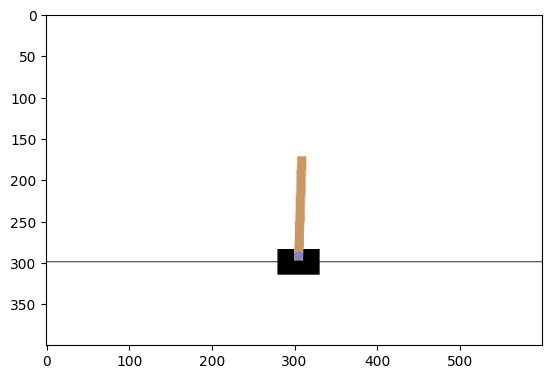

In [8]:
plt.imshow(env.render())

`env.render()` returns an rgb array representing our environment which we can plot using matplotlib's `imshow()` method !

In [ ]:
from time import sleep


env = gymnasium.make(env_name, render_mode="human")

for _ in range(5):
    env.reset()
    termination = False
    while termination is not True:
        _, _, termination, _, _ = env.step(env.action_space.sample())

env.close()

: 

With this simple loop, we can see how our agent fares when it chooses an action at random. Not so well, huh ? Well let's train it using REINFORCE and see how it improves !

Here's the REINFORCE algorithm as defined in Chapter 13 of [Sutton and Bartol's 'Reinforcement Learning: an Introduction'](http://incompleteideas.net/book/RLbook2020.pdf):

![REINFORCE algorithm](./assets/fig15.svg)

Let's begin by setting up a few lists we'll be using for logging our reward and loss...

In [ ]:
# Import the deque class from the collections module
from collections import deque

# Initialize empty lists for rewards and losses
recent_rewards = deque(maxlen=100)
train_rewards = []
train_loss = []

# We will avoid rendering our environment during training: 
# it would tremendously slow down the process
env = gym.make(env_name) 

Now, it's up to you to implement the REINFORCE algorithm using OpenAI Gym's Cartpole environment !

Let's begin by defining our policy:

>- Create a `policy_action()` method which returns an action based on the policy
>- Check out [Pytorch's Categorial Class](https://pytorch.org/docs/stable/distributions.html) which provides a great tool for probability distributions.\
>The provided link explains its usage within REINFORCE in particular ! 

In [ ]:
from torch.distributions import Categorical

def policy_action(self, state):
    # Get the probabilities for each action, using the current state
    
    # Create a distribution according to the probabilities

    # Sample an action from the distribution

    # Return the chosen action
    pass

NeuralNetwork.policy_action = policy_action

Next up, we need to define a simple method which stores our `action, state, reward` tuple at each time step.

>- Simply add the arguments, `Action, State, Reward`, to their respective lists inside the `network` object.

In [ ]:
def remember(self, Action, State, Reward):
    pass
    
NeuralNetwork.remember = remember

Now, we need to compute our discounted rewards for each time step, in other words, the 'G' variable in the algorithm:

You can think of discounting as a way to help the agent become a better long-term planner as opposed to a short-term opportunist. We do this by discounting the value of rewards based on the time step.

$$ G = \sum_{k=t+1}^{T} \gamma^{k-t-1} R_k $$

What this means:

- We need to return a list of `T` numbers (`T` being the episode length in steps)
  - Each of these numbers ( $ \sum^{T}_{k=t+1} $ ) is defined as such: 
    - $ \gamma^{k-t-1} * R_k $

- You are free to achieve this using either loops or `numpy` methods like [`power()`](https://numpy.org/doc/stable/reference/generated/numpy.power.html) and [`cumsum`](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html)

- Don't forget we've declared a `gamma` constant at the top of the notebook !

In [ ]:
def discount_rewards(self):
    ## Discount the returns using the discount factor
    pass

NeuralNetwork.discount_rewards = discount_rewards

network.rewards = [0.2, 0.6, 0.1, 1.2, 0.9]
network.discount_rewards()

Expected output: `[2.9602269 , 2.7602269 , 2.1632269 , 2.0642244 , 0.88213455]`
> If your values are close to these, it means you've correctly implemented the discounting.

Finally, let's implement our gradient ascent !

Since Adam, our optimizer, does most of the job for us, we only need to provide it the correct loss.\
In REINFORCE, the loss is defined as follows:

$$ L = G \nabla \ln \pi(A_t|S_t,\theta) $$

The $ \nabla $ symbol represents the gradient, so you can understand this formula as: `loss = G * log_prob` 

Because we are attempting to find the parameters of our policy which **maximize** the expected cumulative reward, we will not use the familiar **gradient descent** and instead use what is known as **gradient ascent**.

Fear not, because it is not very complicated !

With gradient descent, we update the parameters in the opposite direction of the gradient, which decreases the training cost or the expected cumulative reward, in this case.

So in order to use gradient **ascent**, we must aim to **increase** the expected cumulative reward. Which means we 
can achieve this by simply doing a `backward()` on a negative loss !

This leads us back to the Monte Carlo formula for value-based methods:

$$ G_t - V(S_t) $$

or, for policy-based methods:

$$ G[- \nabla \ln \pi(A_t|S_t,\theta)] $$

In [ ]:
def gradient_ascent(self, discounted_rewards):
    # Perform gradient ascent to update the probabilities in the distribution
    for State, Action, G in zip(self.states, self.actions, discounted_rewards):
        # Get the probabilities for the current state
        probs = None

        # Calculate the loss as the negative log probability of the chosen action
        # multiplied by the discounted return
        loss = None

        # Clear the gradients, backpropagate the loss, and update the network parameters
        
        
        
        #

NeuralNetwork.gradient_ascent = gradient_ascent

All that remains is to use this `NeuralNetwork` class inside a training loop to make our agent learn how to solve Cartpole using the REINFORCE algorithm !

We'll leave this part up to you ! (Use the screenshot of the REINFORCE pseudo code from earlier in the notebook for reference)

In [ ]:
# Iterate over the number of episodes
for episode in range(episodes):
    # Reset the environment and initialize empty lists for actions, states, and rewards
    state, _  = env.reset()
    network.actions, network.states, network.rewards = [], [], []

    # Train the agent for a single episode
    for _ in range(1000):
        action = network.policy_action(state)

        # Take the action in the environment and get the new state, reward, and done flag
        new_state, reward, termination, truncation, _ = env.step(action)

        # Save the action, state, and reward for later
        network.remember(action, state, reward)

        state = new_state

        # If the episode is done or the time limit is reached, stop training
        if termination or truncation:
            break

    # Perform gradient ascent
    network.gradient_ascent(network.discount_rewards())

    # Save the total reward for the episode and append it to the recent rewards queue
    train_rewards.append(np.sum(network.rewards))
    recent_rewards.append(train_rewards[-1])

    # Print the mean recent reward every 50 episodes
    if episode % 50 == 0:
        print(f"Episode {episode:>6}: \tR:{np.mean(recent_rewards):>6.3f}")

    if np.mean(recent_rewards) > 400:
        break

In [ ]:
fig, ax = plt.subplots()

ax.plot(train_rewards)
ax.plot(gaussian_filter1d(train_rewards, sigma=20), linewidth=4)
ax.set_title('Rewards')

fig.show()

Finally, let's display five episodes of our trained agent to see how glorious it is:

In [ ]:
env = gym.make(env_name, render_mode="human")

for _ in range(5):
    Rewards = []
    
    state, _ = env.reset()
    done = False
    
    for _ in range(1000):
        # Calculate the probabilities of taking each action using the trained
        # neural network
        probs = network.forward(state)
        
        # Sample an action from the resulting distribution using the 
        # torch.distributions.Categorical() method
        action = None
    
        new_state, reward, termination, truncation, _ = env.step(action)
    
        state = new_state

        Rewards.append(reward)

        if termination or truncation:
            break
    
    # Print the total rewards for the current episode
    print(f'Reward: {sum(Rewards)}')

# Close the environment
env.close()

Wow, you really did it ! You've succesfully implemented both a value-based and a policy-based method in reinforcement learning ! And, to top it all off, you even managed to solve CartPole using OpenAI Gym !

If you're up for it, let's head over to section 2 and go **deeper** within the field of RL by returning to value-based methods and implementing the successor to Q-Learning, Deep Q Network, or DQN for short !

Good luck !